In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [10]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv


--2021-10-09 10:35:04--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.1’

CreditScoring.csv.1 100%[===================>] 178.21K  --.-KB/s    in 0.03s   

2021-10-09 10:35:05 (5.98 MB/s) - ‘CreditScoring.csv.1’ saved [182489/182489]



### Data Preparation

In [11]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

In [12]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [13]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

#### Prepare the numerical variables:

In [14]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

#### Remove clients with unknown default status

In [15]:
df = df[df.status != 'unk'].reset_index(drop=True)

#### Create the target variable

In [16]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

In [17]:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int64
dtype: object

In [18]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [20]:
data_class = df.copy()

df_train_full, df_test = train_test_split(data_class, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [21]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [22]:
y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

#### understanding correlation between the numerical variables and the target variable

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
df_train_full[numerical].corrwith(df_train_full.default)

seniority   -0.268613
time         0.108242
age         -0.112415
expenses     0.031822
income      -0.229158
assets      -0.102810
debt         0.012648
amount       0.144612
price        0.000468
dtype: float64

In [25]:
del df_train['default']
del df_val['default']
del df_test['default']

#### Q1: Which numerical variable (among the following 4) has the highest AUC?

In [26]:
from sklearn.metrics import roc_auc_score

In [27]:
roc_auc_seniority = roc_auc_score(y_train, -df_train['seniority'])

In [28]:
roc_auc_time = roc_auc_score(y_train, df_train['time'])
roc_auc_time

0.5608662489595051

In [29]:
roc_auc_income = roc_auc_score(y_train, -df_train['income'])
roc_auc_income

0.682006666132633

In [30]:
roc_auc_debt = roc_auc_score(y_train, -df_train['debt'])
roc_auc_debt

0.5047829675783548

In [31]:
print("roc scores",roc_auc_seniority, roc_auc_time, roc_auc_income, roc_auc_debt)

roc scores 0.7093778624491943 0.5608662489595051 0.682006666132633 0.5047829675783548


#### Training the model

#### AUC of this model on the validation dataset?

In [32]:
feature_set = ['seniority', 'income', 'assets', 'records', 'job', 'home']

dv = DictVectorizer(sparse=False)
train_dict = df_train[feature_set].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train,y_train)

val_dict = df_val[feature_set].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

from sklearn import metrics

print(metrics.roc_auc_score(y_val, y_pred).round(3))



0.811


#### Compute Precision and Recall for the model

In [33]:
th = np.arange(0,1,0.01)
th

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [34]:
scores = []

thresholds = np.arange(0,1,0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [35]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

df_scores

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,246,645,0,0,0.276094,1.00000
1,0.01,246,635,0,10,0.279228,1.00000
2,0.02,244,610,2,35,0.285714,0.99187
3,0.03,242,591,4,54,0.290516,0.98374
4,0.04,242,562,4,83,0.300995,0.98374
...,...,...,...,...,...,...,...
95,0.95,0,0,246,645,NaN,0.00000
96,0.96,0,0,246,645,NaN,0.00000
97,0.97,0,0,246,645,NaN,0.00000
98,0.98,0,0,246,645,NaN,0.00000


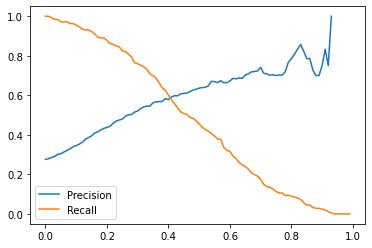

In [36]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()

#### Q3 : Precision and recall intersect at 0.4

#### Compute F1 score

In [37]:
df_scores['f1_score'] = (2 * df_scores['precision'] * df_scores['recall']) / (df_scores['precision'] + df_scores['recall'])
df_scores

,threshold,tp,fp,fn,tn,precision,recall,f1_score
0,0.00,246,645,0,0,0.276094,1.00000,0.432718
1,0.01,246,635,0,10,0.279228,1.00000,0.436557
2,0.02,244,610,2,35,0.285714,0.99187,0.443636
3,0.03,242,591,4,54,0.290516,0.98374,0.448563
4,0.04,242,562,4,83,0.300995,0.98374,0.460952
...,...,...,...,...,...,...,...,...
95,0.95,0,0,246,645,NaN,0.00000,NaN
96,0.96,0,0,246,645,NaN,0.00000,NaN
97,0.97,0,0,246,645,NaN,0.00000,NaN
98,0.98,0,0,246,645,NaN,0.00000,NaN


In [38]:
df_scores['f1_score'].max()

0.6267123287671232

In [39]:
np.where(df_scores['f1_score'] == df_scores['f1_score'].max())

(array([32]),)

In [40]:
df_scores.iloc[32]

threshold      0.320000
tp           183.000000
fp           155.000000
fn            63.000000
tn           490.000000
precision      0.541420
recall         0.743902
f1_score       0.626712
Name: 32, dtype: float64

#### F1 score max for threshold 0.3

#### Use KFold to evaluate the AUC and compute the Standard Deviation

In [41]:
from sklearn.model_selection import KFold

In [42]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[feature_set].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    return dv, model

In [43]:
def predict(df, dv, model):
    dicts = df[feature_set].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [44]:
for C in [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))


C=0.01 0.809 +- 0.013
C=0.1 0.813 +- 0.014
C=1 0.813 +- 0.015
C=10 0.814 +- 0.015


#### Std deviation is around +-0.015

#### Best mean score 0.814 for C = 10

In [45]:
import pickle

In [46]:
C = 1.0
output_file = f'model_C={C}.bin'
output_file

'model_C=1.0.bin'

In [48]:
dv, model = train(df_train_full, df_train_full.default.values, C=1.0)



In [50]:
with open(output_file,'wb') as f_out:
    pickle.dump((dv, model),f_out)

In [2]:
import pickle

In [3]:
model_file = 'model_C=1.0.bin'

In [4]:
with open(model_file,'rb') as f_in:
    dv, model = pickle.load(f_in)

In [5]:
dv, model

(DictVectorizer(sparse=False),
 LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'))